In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import electronbeam
from beam.elements import plasma
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
plt.rcParams['animation.ffmpeg_path'] = '/home/robert/anaconda3/envs/CU-PWFA/bin/ffmpeg'
import matplotlib.animation as animation
from scipy.optimize import curve_fit

path = '/media/robert/Data_Storage/Data/Tests/Test_Electron_Beam_2/'

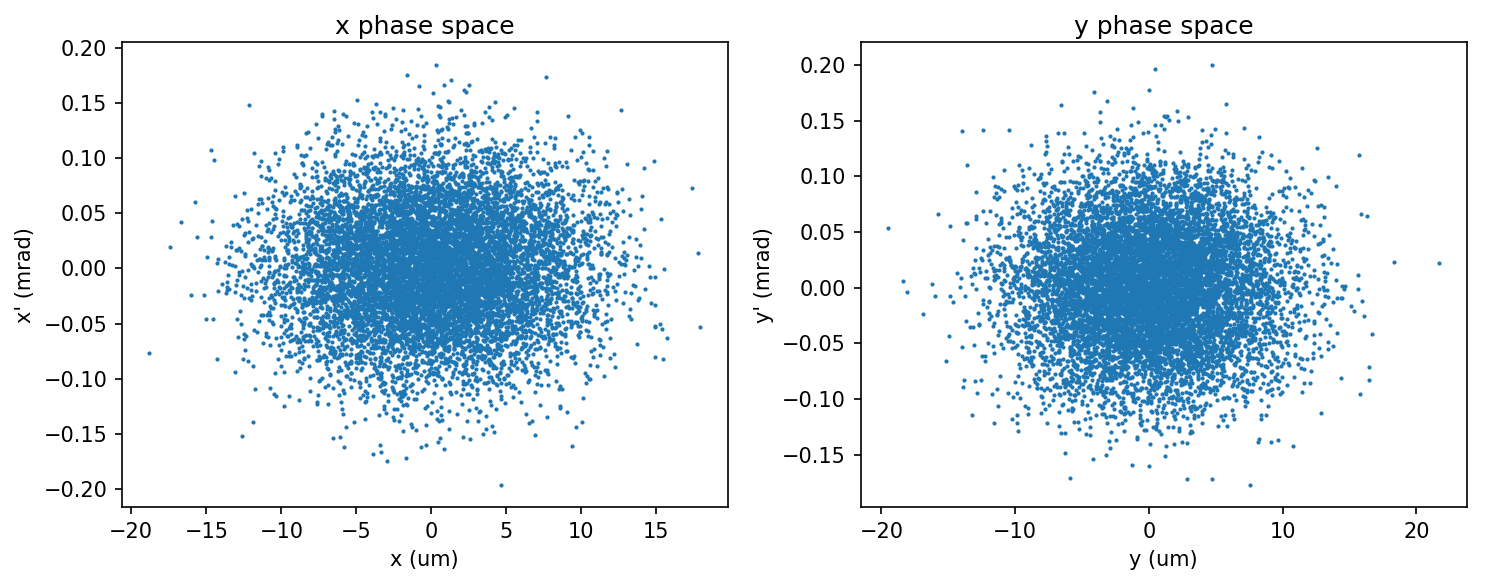

In [ ]:
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : 20000,
    'emittance' : 5e-6,
    'betax' : 0.10,
    'betay' : 0.10,
    'alphax' : 0.0,
    'alphay' : 0.0,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

In [ ]:
# Now we can create a very simple plasma and propagate the beam through it
Nx = 50
Ny = 50
Nz = 500
dumpPeriod = 1
def dgammadz(ne):
    return 0.0
plasmaParams ={
    'name' : 'TestPlasma',
    'path' : path,
    'load' : False,
    'Nx' : Nx,
    'Ny' : Ny,
    'Nz' : Nz,
    'X' : 100,
    'Y' : 100,
    'Z' : 1e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'cyl' : False,
    'dgammadz' : dgammadz
}
m = int(Nz/dumpPeriod)
if dumpPeriod ==1:
    m -= 1
argon = plasma.Plasma(plasmaParams)
n = plasmaParams['n0']*np.ones((Nx, Ny, Nz), dtype='double')
ne = n
argon.initialize_plasma(n, ne)
interactions.electron_plasma(beam, argon, argon.z, dumpPeriod, 4)
beam.plot_current_phase()
print('Initial emittance:', np.average(beam.get_emittance_n(0))*1e6, 'mm.mrad')
print('Final emittance:', np.average(beam.get_emittance_n(m))*1e6, 'mm.mrad')

In [ ]:
# Lets track a single particle
ind = 0
ptcl = np.zeros((m+1, 6), dtype='double')
for i in range(m):
    ptcl[i, :] = beam.load_ptcls(i)[0][ind, :]
z = np.array(beam.z, dtype='double')
kp = 5.95074e4 * np.sqrt(plasmaParams['n0'])
kb = kp/np.sqrt(2*ptcl[0, 5])
print(kb)
norm = np.sqrt(ptcl[:, 0]**2+(ptcl[:, 1]/kb)**2)*1e6

def func(x, a, b):
    return a*np.exp(-x/b)
popt, pcov = curve_fit(func, z, norm)
print(popt[1])

plt.plot(z, ptcl[:, 0]*1e6, z, ptcl[:, 1]*1e6/kb, z, norm, z, func(z, *popt))
plt.title('Transverse position of a particle in a uniform plasma')
plt.xlabel('s (m)')
plt.ylabel(r'x ($\mu m$)')
plt.show()

In [ ]:
# Now time to animate phase space
ptcls, z = beam.load_ptcls(0)
#fig, sctx, scty = beam.plot_phase(ptcls, z, )#xlim=[-400, 400])
i = 1
def updatefig(*args):
    global i
    ptcls = beam.load_ptcls(i)[0]
    sctx.set_offsets(np.stack((ptcls[:, 0]*1e6, ptcls[:, 1]*1e3), axis=-1))
    scty.set_offsets(np.stack((ptcls[:, 2]*1e6, ptcls[:, 3]*1e3), axis=-1))
    i += 1
    return sctx, scty,
#ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=m-3)
#ani.save(path + 'PhaseSpaceEvolution.mp4', fps=30)